## Задание

Добейтесь на автокодировщике с 2-мерным скрытым пространством на 3-х цифрах: 0, 1 и 3 – ошибки MSE**<0.034** на скорости обучения **0.001** на **10-й эпохе**.

## Импорт библиотек


In [ ]:
# Работа с операционной системой
import os

# Отрисовка графиков
import matplotlib.pyplot as plt 

# Операции с путями
import glob

# Работа с массивами данных
import numpy as np

# Слои
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Concatenate

# Модель
from tensorflow.keras import Model

# Загрузка модели
from tensorflow.keras.models import load_model

# Датасет
from tensorflow.keras.datasets import mnist

# Оптимизатор для обучения модели
from tensorflow.keras.optimizers import Adam

# Коллбэки для выдачи информации в процессе обучения
from tensorflow.keras.callbacks import LambdaCallback

%matplotlib inline

## Утилиты

Функция-коллбэк. Отрисовывает объекты в скрытом пространстве

In [ ]:
def ae_on_epoch_end(epoch, logs):
    print('________________________')  
    print(f'*** ЭПОХА: {epoch+1}, loss: {logs["loss"]} ***')
    print('________________________')  
    
    # Получение картинки латентного пространства в конце эпохи и запись в файл
    # Задание числа пикселей на дюйм
    plt.figure(dpi=100)

    # Предсказание енкодера на тренировочной выборке
    predict = encoder.predict(X_train)

    # Создание рисунка: множество точек на плоскости 3-х цветов (3-х классов)
    scatter = plt.scatter(predict[:,0,],predict[:,1], c=y_train, alpha=0.6, s=5)

    # Создание легенды
    legend2 = plt.legend(*scatter.legend_elements(), loc='upper right', title='Классы')

    # Сохранение картинки с названием, которого еще нет
    paths = glob.glob('*.jpg')
    plt.savefig(f'image_{str(len(paths))}.jpg')

    # Отображение. Без него рисунок не отрисуется
    plt.show()


ae_callback = LambdaCallback(on_epoch_end=ae_on_epoch_end)

Удаление изображений. Применять при обучении новой модели, чтобы не было путаницы в картинках.

In [ ]:
def clean():
  # Получение названий всех картинок
  paths = glob.glob('*.jpg')

  # Удаление всех картинок по полученным путям
  for p in paths:
    os.remove(p)

# Удаление всех картинок
clean()

## Загрузка данных

In [ ]:
# Загрузка датасета
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
# Нормировка -1 останятся все примеры
X_train = X_train.astype('float32')/255.
X_train = X_train.reshape(-1, 28, 28, 1)

In [ ]:
X_train.shape

(60000, 28, 28, 1)

In [ ]:
# Выбор визуализируемых классов (цифр) и формирование подвыборок для них по маске
numbers = [0, 1, 3]
mask = np.array([(i in numbers) for i in y_train])
X_train = X_train[mask]
y_train = y_train[mask]

## Создание модели и обучение

In [ ]:
# Ваше решение

Состав блока:
Двумерная свертка.
Нормализация.
Двумерная свертка.
Нормализация.
Снижение размерности.

In [ ]:
# Функция сборки сверточного автокодировщика
def create_base_ae(in_shape):
    # Энкодер, вход нейросети
    img_input = Input(in_shape)

    # Энкодер, первый блок
    #Состав блока: Двумерная свертка. Нормализация. Двумерная свертка. Нормализация. Снижение размерности.


    # 1.1. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) 
    # 1.2. Нормализация
    x = BatchNormalization()(x)
    # 1.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    # 1.4. Нормализация
    x = BatchNormalization()(x)
    # 1.5. Снижение размерности и обобщение данных
    x = MaxPooling2D()(x)

    # Энкодер, второй блок
    # 2.1. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    # 2.2. Нормализация
    x = BatchNormalization()(x)
    # 2.3. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 2.4. Нормализация
    x = BatchNormalization()(x)
    
    
    # На выходе кодировщика и на входе декодировщика z - вектор латентного пространства
    # 2.5. Снижение размерности и обобщение данных
    z = MaxPooling2D()(x)
        

    # Декодер, первый блок
    #Состав блока: Повышение размерности. Нормализация. Двумерная свертка. Нормализация Двумерная свертка. Нормализация.


    # 1.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z)
    # 1.2. Нормализация
    x = BatchNormalization()(x) 
    # 1.3. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 1.4. Нормализация
    x = BatchNormalization()(x) 
    # 1.5. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 1.6. Нормализация
    x = BatchNormalization()(x)

    # Декодер, второй блок
    # 2.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 
    # 2.2. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    # 2.4. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.5. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    # 2.6. Нормализация
    x = BatchNormalization()(x) 

    # Декодер, финальный слой двумерной свертки, выдающий итоговое изображение
    outputs = Conv2D(in_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)



    #После двух блоков декодера идет финальный слой двумерной свертки декодера, который выдает итоговое изображение. 
    #Прописав структуру автокодировщика, вам остается собрать ее model = Model(inputs, outputs), 
    #в которой на вход подается оригинальное изображение, а на выходе – изображение после сжатия и его восстановления. 
    #Компилируйте сеть, используя оптимизатор Adam и ошибку mse. 
    #Так как модель создана в функции, ее нужно вернуть посредством return model.

    # Сборка модели, на входе оригинальное изображение, на выходе - сжатое-восстановленное
    model = Model(inputs=img_input, outputs=outputs) 

    # Компиляция сети, назначение оптимизатора Adam + среднеквадратическая ошибка
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse') 

    # Возврат готовой модели
    return model 

Теперь пропишите еще одну функцию plot_images(x_data, pred, shape=None, n=3), которая выведет n – количество изображений каждого типа. У функции четыре параметра:
x_data – оригинальные изображения;
pred – изображения после автокодировщика;
n – количество изображений каждого типа.

In [ ]:
# Функция последовательного вывода нескольких изображений для сравнения
def plot_images(x_data, pred, n=5): 

    plt.figure(figsize=(14, 7))                     # Размер полотна

    for i in range(1, n + 1):                              # Повтор n раз:
        index = np.random.randint(0, pred.shape[0]) # Выбор случайного индекса 

        # Показ картинки с индексом index из набора x_data
        ax = plt.subplot(2, n, i)               # Картинка располагается в верхнем ряду
        plt.imshow(x_data[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False) 

        # Показ картинки с тем же индексом из предсказания автокодировщика
        ax = plt.subplot(2, n, i + n)           # Картинка располагается в нижнем ряду
        plt.imshow(pred[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
# Проверка формы данных
print(X_train.shape)
print(y_train.shape)

(18796, 28, 28, 1)
(18796,)


In [ ]:
# Проверка формы данных
print(X_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


In [ ]:
# Нормировка -1 останятся все примеры
X_test = X_test.astype('float32')/255.
X_test = X_test.reshape(-1, 28, 28, 1)

In [ ]:
X_test.shape

(10000, 28, 28, 1)

In [ ]:
# Выбор визуализируемых классов (цифр) и формирование подвыборок для них по маске
numbers = [0, 1, 3]
mask1 = np.array([(i in numbers) for i in y_test])
X_test = X_test[mask1]
y_test = y_test[mask1]

In [ ]:
# Проверка формы данных
print(X_test.shape)
print(y_test.shape)

(3125, 28, 28, 1)
(3125,)


In [ ]:
# Сборка автокодировщика для формы картинок датасета
ae_mnist = create_base_ae(X_train.shape[1:])

In [ ]:
# Сводка архитектуры автокодировщика
ae_mnist.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0     

In [ ]:
# Функции-утилиты
from tensorflow.keras import utils

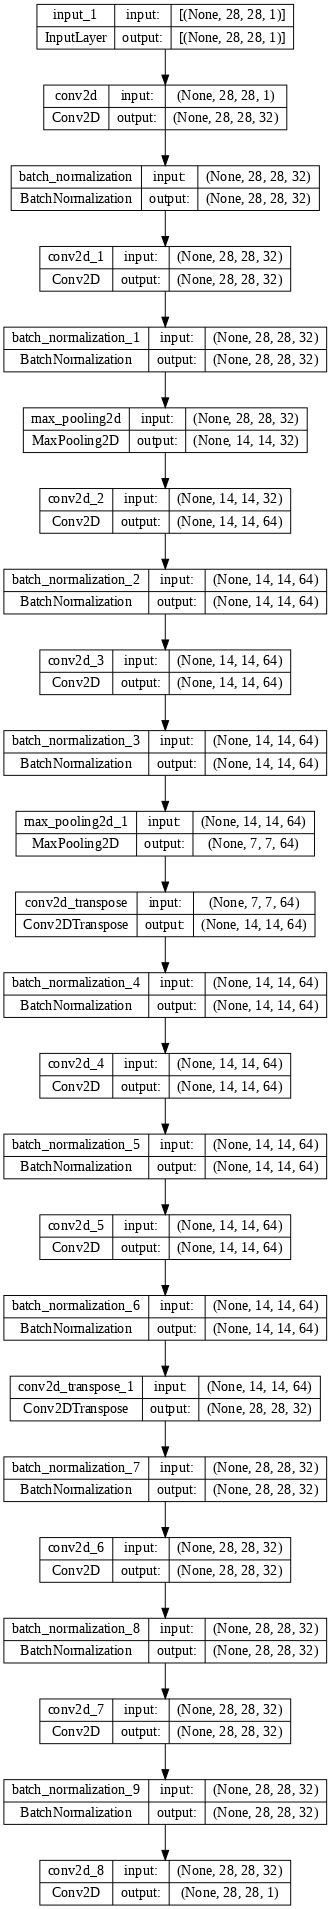

In [ ]:
# Визуальная схема архитектуры модели
utils.plot_model(ae_mnist, 
                 dpi=70,                  # число точек на дюйм (дюйм = 2.54 см)
                 show_shapes=True         # отображение ожидаемых форм входных и выходных тензоров каждого слоя
                 )

In [ ]:
# Обучение модели автокодировщика, на входе и выходе одни и те же данные
history = ae_mnist.fit(X_train, X_train,
                       epochs=10,
                       batch_size=256,
                       validation_data = (X_test, X_test))

Epoch 1/10
74/74 [==============================] - 14s 56ms/step - loss: 0.0409 - val_loss: 0.1012
Epoch 2/10
74/74 [==============================] - 4s 48ms/step - loss: 0.0062 - val_loss: 0.1058
Epoch 3/10
74/74 [==============================] - 4s 48ms/step - loss: 0.0041 - val_loss: 0.0925
Epoch 4/10
74/74 [==============================] - 3s 46ms/step - loss: 0.0032 - val_loss: 0.0425
Epoch 5/10
74/74 [==============================] - 4s 48ms/step - loss: 0.0027 - val_loss: 0.0136
Epoch 6/10
74/74 [==============================] - 3s 46ms/step - loss: 0.0023 - val_loss: 0.0067
Epoch 7/10
74/74 [==============================] - 3s 46ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 8/10
74/74 [==============================] - 4s 48ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 9/10
74/74 [==============================] - 4s 48ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 10/10
74/74 [==============================] - 4s 48ms/step - loss: 0.0016 - val_loss: 0.0018


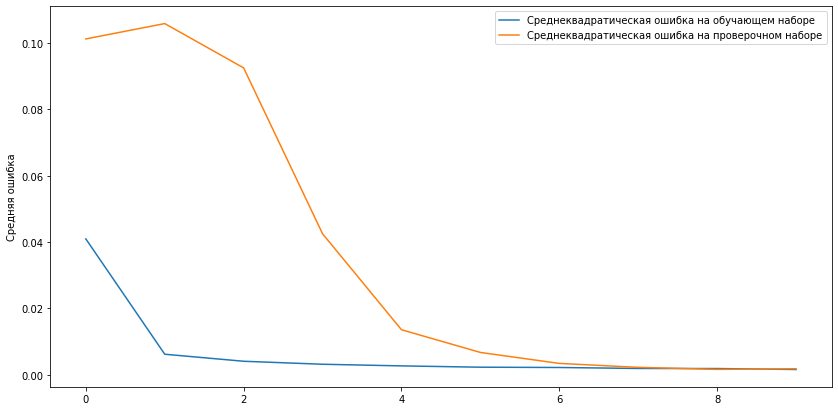

In [ ]:
# Вывод графиков процесса обучения
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][0:], 
         label='Среднеквадратическая ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][0:], 
         label='Среднеквадратическая ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
# путь к папке для хранения моделей
PATH = '/content/my_ae_models'

# создадим папку для моделей, если её еще нет
if not os.path.isdir(PATH):
  os.mkdir(PATH)

In [ ]:
# Сохранение/восстановление параметров модели
ae_mnist.save_weights(PATH + '/ae_mnist.h5') # Сохраняем модель
ae_mnist.load_weights(PATH + '/ae_mnist.h5') # Загружаем модель

In [ ]:
# Получение предсказания автокодировщика на тренировочной и тестовой выборках
pred_train_mnist = ae_mnist.predict(X_train)
pred_test_mnist = ae_mnist.predict(X_test)

98/98 [==============================] - 0s 4ms/step


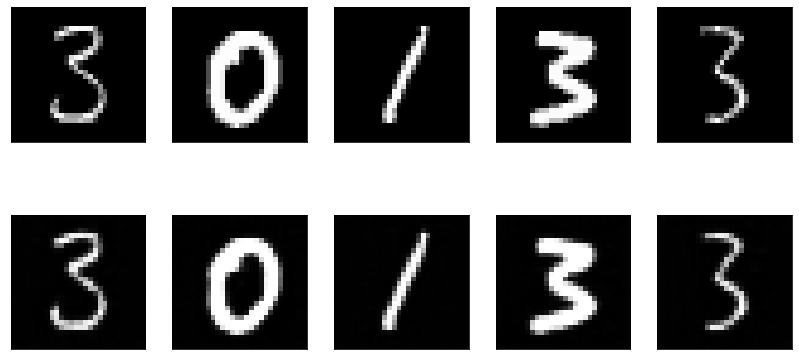

In [ ]:
# Сравнение исходных и восстановленных картинок из тестовой выборки
plot_images(X_test, pred_test_mnist)

In [ ]:
# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error


In [ ]:
# Расчет количества пикселей изображения
image_size = X_train.shape[1] * X_train.shape[2]

# Расчет массивов среднеквадратических ошибок по всем картинкам тренировочной и тестовой выборок.
# mean_squared_error() ожидает двумерный вектор, для чего каждую картинку придется
# "сплющить" до одномерного вектора размера image_size
err_train_mnist = mean_squared_error(X_train.reshape(-1, image_size).T, 
                                     pred_train_mnist.reshape(-1, image_size).T,
                                     multioutput='raw_values')
err_test_mnist = mean_squared_error(X_test.reshape(-1, image_size).T,
                                    pred_test_mnist.reshape(-1, image_size).T,
                                    multioutput='raw_values')

# Вывод средних ошибок
print(f'Средняя ошибка на обучающем наборе MNIST: {err_train_mnist.mean()}')
print(f'Средняя ошибка на  тестовом наборе MNIST: {err_test_mnist.mean()}')

Средняя ошибка на обучающем наборе MNIST: 0.001809142529964447
Средняя ошибка на  тестовом наборе MNIST: 0.001816573436371982
